# SHD CNN Baseline Implementation

根據 Cramer et al. (2020) "The Heidelberg Spiking Data Sets" 論文附錄 B 和 C 實現

僅處理 10 個英文類別（0-9）

In [17]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from pathlib import Path



## 1. 資料集類別 (SHDDataset)

處理 HDF5 檔案載入和時空分箱

In [18]:
class SHDDataset(Dataset):
    """SHD 資料集類別，處理 HDF5 檔案載入和時空分箱"""
    
    def __init__(self, h5_file_path, time_bin_size_ms=10, target_channels=64, max_time_ms=None):
        """
        初始化資料集
        
        Args:
            h5_file_path: HDF5 檔案路徑
            time_bin_size_ms: 時間分箱大小（毫秒），預設 10ms
            target_channels: 目標通道數，預設 64
            max_time_ms: 最大時間長度（毫秒），None 表示使用資料中的最大值
        """
        self.time_bin_size_ms = time_bin_size_ms
        self.target_channels = target_channels
        self.original_channels = 700
        
        # 載入 HDF5 檔案
        with h5py.File(h5_file_path, 'r') as f:
            # 讀取標籤（先讀取以確定樣本數）
            if 'labels' in f:
                all_labels = f['labels'][:]
            elif 'y' in f:
                all_labels = f['y'][:]
            else:
                raise ValueError(f"無法找到標籤資料，可用的鍵: {list(f.keys())}")
            
            total_samples = len(all_labels)
            
            # 讀取 spike 事件資料
            # SHD 資料集結構：spikes/times 和 spikes/units
            if 'spikes' in f:
                spikes_group = f['spikes']
                times_data = spikes_group['times']
                units_data = spikes_group['units']
                
                # 檢查是否有索引結構
                if 'idx' in spikes_group:
                    # 使用索引結構
                    self.indices = spikes_group['idx'][:]
                    self.use_indices = True
                else:
                    # 沒有索引，假設每個樣本對應一個元素（可能是嵌套結構）
                    self.indices = None
                    self.use_indices = False
                    
                    # 檢查資料結構
                    if hasattr(times_data, 'shape') and len(times_data.shape) == 1:
                        # 扁平陣列（可能是可變長度陣列，如處理後的檔案）
                        # 這種情況下，每個元素對應一個樣本（嵌套結構）
                        # 這是正常的，不需要警告
                        self.use_indices = False
            else:
                raise ValueError(f"無法找到 spike 資料，可用的鍵: {list(f.keys())}")
            
            # 檢查是否已經只包含英文類別（處理後的檔案）
            # 如果所有標籤都 < 10，則已經過濾過，不需要再次過濾
            if np.all(all_labels < 10):
                # 已經只包含英文類別，直接使用所有樣本
                self.english_indices = np.arange(len(all_labels))
                self.labels = all_labels
                self.num_samples = len(self.labels)
            else:
                # 需要過濾出僅英文類別（0-9）
                english_mask = all_labels < 10
                self.english_indices = np.where(english_mask)[0]
                self.labels = all_labels[english_mask]
                self.num_samples = len(self.labels)
            
            # 儲存檔案路徑和資料引用以便後續讀取
            self.h5_file_path = h5_file_path
        
        # 計算最大時間長度（需要讀取所有樣本來確定）
        if max_time_ms is None:
            max_time_ms = self._compute_max_time()
        self.max_time_ms = max_time_ms
        self.max_time_bins = int(np.ceil(max_time_ms / time_bin_size_ms))
        
        print(f"載入資料集: {h5_file_path}")
        print(f"  樣本數: {self.num_samples}")
        print(f"  最大時間: {max_time_ms:.1f} ms")
        print(f"  時間分箱數: {self.max_time_bins}")
        print(f"  類別數: {len(np.unique(self.labels))}")
    
    def _compute_max_time(self):
        """計算資料集中的最大時間（單位：毫秒）"""
        max_time_ms = 0.0
        with h5py.File(self.h5_file_path, 'r') as f:
            spikes_group = f['spikes']
            times_data = spikes_group['times']
            
            # 讀取所有樣本的時間（取樣以加快速度）
            sample_indices = self.english_indices[:min(500, len(self.english_indices))]
            for idx in sample_indices:
                try:
                    # 直接索引獲取嵌套陣列
                    sample_times = times_data[idx]
                    # 如果是 h5py Dataset 或 numpy array，讀取它
                    if isinstance(sample_times, (h5py.Dataset, np.ndarray)):
                        if hasattr(sample_times, '__len__') and len(sample_times) > 0:
                            # 時間單位是秒，轉換為毫秒
                            max_time_sec = float(np.max(sample_times))
                            max_time_ms = max(max_time_ms, max_time_sec * 1000.0)
                except Exception as e:
                    # 如果讀取失敗，跳過這個樣本
                    continue
        
        # 如果沒有找到有效時間，使用預設值（約 1 秒 = 1000 毫秒）
        return max_time_ms if max_time_ms > 0 else 1000.0
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        """
        獲取單一樣本並進行時空分箱
        """
        # 獲取實際的樣本索引（如果已過濾則直接使用，否則使用過濾後的索引）
        actual_idx = self.english_indices[idx]
        
        # 從 HDF5 檔案讀取該樣本的 spike 資料
        with h5py.File(self.h5_file_path, 'r') as f:
            spikes_group = f['spikes']
            times_data = spikes_group['times']
            units_data = spikes_group['units']
            
            # 根據索引結構讀取樣本
            try:
                # 直接索引獲取嵌套陣列（SHD 資料集使用嵌套結構）
                sample_times = times_data[actual_idx]
                sample_units = units_data[actual_idx]
                
                # 如果是 h5py Dataset 或 numpy array，讀取它
                if isinstance(sample_times, (h5py.Dataset, np.ndarray)):
                    if hasattr(sample_times, '__len__'):
                        sample_times = np.array(sample_times, dtype=np.float32)
                    else:
                        sample_times = np.array([sample_times], dtype=np.float32)
                else:
                    sample_times = np.array(sample_times, dtype=np.float32)
                
                if isinstance(sample_units, (h5py.Dataset, np.ndarray)):
                    if hasattr(sample_units, '__len__'):
                        sample_units = np.array(sample_units, dtype=np.int32)
                    else:
                        sample_units = np.array([sample_units], dtype=np.int32)
                else:
                    sample_units = np.array(sample_units, dtype=np.int32)
                    
            except Exception as e:
                # 如果失敗，返回空樣本
                print(f"警告: 無法讀取樣本 {actual_idx}: {e}")
                sample_times = np.array([], dtype=np.float32)
                sample_units = np.array([], dtype=np.int32)
        
        # 建立時空分箱張量
        time_bins = self.max_time_bins
        spatial_bins = self.target_channels
        
        # 初始化分箱張量
        binned_data = np.zeros((time_bins, spatial_bins), dtype=np.float32)
        
        # 時空分箱處理
        # 注意：HDF5 中的時間單位是秒，需要轉換為毫秒
        for time_sec, unit in zip(sample_times, sample_units):
            # 將時間從秒轉換為毫秒
            time_ms = float(time_sec) * 1000.0
            
            if time_ms > self.max_time_ms:
                continue
            
            # 時間分箱：將 spike 時間映射到時間分箱
            time_bin = int(time_ms / self.time_bin_size_ms)
            if time_bin >= time_bins:
                time_bin = time_bins - 1
            if time_bin < 0:
                time_bin = 0
            
            # 空間分箱：將 700 通道映射到 64 通道
            # 確保 unit 在有效範圍內
            unit = int(unit) % self.original_channels
            spatial_bin = int(unit * self.target_channels / self.original_channels)
            if spatial_bin >= spatial_bins:
                spatial_bin = spatial_bins - 1
            if spatial_bin < 0:
                spatial_bin = 0
            
            # 設定 spike（使用二進制表示）
            binned_data[time_bin, spatial_bin] = 1.0
        
        # 轉換為 PyTorch 張量並添加通道維度
        # 輸出格式: [1, Time_Bins, 64]
        tensor_data = torch.from_numpy(binned_data).unsqueeze(0)
        
        # 獲取標籤
        label = int(self.labels[idx])
        
        return tensor_data, label




## 2. CNN 模型架構 (SHDCNNBaseline)

根據論文附錄 C 實現

In [19]:
class SHDCNNBaseline(nn.Module):
    """SHD CNN Baseline 模型架構（根據論文附錄 C）"""
    
    def __init__(self, num_classes=10):
        super(SHDCNNBaseline, self).__init__()
        
        # 輸入層：2D Convolution (32 filters, kernel size 11x11), ReLU
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=11, padding=5),  # padding 保持尺寸
            nn.ReLU()
        )
        
        # 3 個連續的卷積塊
        def make_conv_block():
            return nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),  # 使用 ceil_mode 避免尺寸為 0
                nn.Dropout(0.2)
            )
        
        self.block1 = make_conv_block()
        self.block2 = make_conv_block()
        self.block3 = make_conv_block()
        
        # 分類頭
        self.flatten = nn.Flatten()
        
        # 使用自適應池化來處理不同尺寸（在最後統一尺寸）
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # 使用較小的尺寸以適應小輸入
        
        self.classifier = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),  # 32 channels * 4 * 4
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Input: [Batch, 1, Time_Bins, 64]
        x = self.input_conv(x)
        
        # 逐個處理卷積塊，檢查尺寸避免錯誤
        x = self.block1(x)
        # 如果尺寸太小，提前使用自適應池化
        if x.shape[2] < 2 or x.shape[3] < 2:
            x = self.adaptive_pool(x)
            x = self.flatten(x)
            x = self.classifier(x)
            return x
        
        x = self.block2(x)
        if x.shape[2] < 2 or x.shape[3] < 2:
            x = self.adaptive_pool(x)
            x = self.flatten(x)
            x = self.classifier(x)
            return x
        
        x = self.block3(x)
        
        # 使用自適應池化統一尺寸
        x = self.adaptive_pool(x)
        
        # Flatten 和分類
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x




## 3. 輔助函數

In [20]:
def collate_fn(batch):
    """自定義批次處理函數，處理不同長度的樣本"""
    data, labels = zip(*batch)
    
    # 找到批次內最大的時間長度
    max_time_bins = max(d.shape[2] for d in data)
    
    # Padding 所有樣本到相同長度
    padded_data = []
    for d in data:
        if d.shape[2] < max_time_bins:
            pad_size = max_time_bins - d.shape[2]
            # 在時間維度上 padding（在末尾）
            padded = torch.nn.functional.pad(d, (0, 0, 0, pad_size), mode='constant', value=0)
            padded_data.append(padded)
        else:
            padded_data.append(d)
    
    # 堆疊成批次
    batch_data = torch.stack(padded_data)
    batch_labels = torch.tensor(labels, dtype=torch.long)
    
    return batch_data, batch_labels


def train_epoch(model, train_loader, criterion, optimizer, device):
    """訓練一個 epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for data, labels in pbar:
        data = data.to(device)
        labels = labels.to(device)
        
        # 前向傳播
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # 反向傳播
        loss.backward()
        optimizer.step()
        
        # 統計
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 更新進度條
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """驗證模型"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for data, labels in pbar:
            data = data.to(device)
            labels = labels.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc




## 4. 設定與初始化

In [21]:
# 設定超參數
epochs = 50
batch_size = 32
learning_rate = 0.001
time_bin_size_ms = 10
target_channels = 64

# 建立必要的目錄
base_dir = Path(".")  # 當前目錄（notebook 環境）
data_dir = base_dir / 'data'
models_dir = base_dir / 'models'
logs_dir = base_dir / 'logs'

data_dir.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)
logs_dir.mkdir(exist_ok=True)

# 設定設備
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"使用 CUDA 設備: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("使用 MPS 設備")
else:
    device = torch.device('cpu')
    print("使用 CPU 設備")

# 為每次訓練創建獨立的實驗目錄
from datetime import datetime
experiment_name = f"experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
experiment_dir = models_dir / experiment_name
experiment_dir.mkdir(exist_ok=True)
print(f"\n實驗目錄: {experiment_dir}")






使用 CUDA 設備: NVIDIA GeForce RTX 4090

實驗目錄: models/experiment_20251212_003103


## 5. 載入資料集

In [22]:
# 優先使用處理後的檔案（英文類別 + Speaker 分割）
hdspikes_dir = data_dir / 'hdspikes'
train_file = hdspikes_dir / 'shd_train_english_speaker_split.h5'
val_file = hdspikes_dir / 'shd_test_english_speaker_split.h5'

# 如果處理後的檔案不存在，回退到原始檔案（會自動過濾英文類別）
if not train_file.exists():
    train_file = data_dir / 'shd_train.h5'
    if not train_file.exists():
        train_file = hdspikes_dir / 'shd_train.h5'

if not val_file.exists():
    val_file = data_dir / 'shd_test.h5'
    if not val_file.exists():
        val_file = hdspikes_dir / 'shd_test.h5'

if not train_file.exists():
    raise FileNotFoundError(f"找不到訓練資料檔案: {train_file}")
if not val_file.exists():
    raise FileNotFoundError(f"找不到驗證資料檔案: {val_file}")

# 顯示使用的檔案
if 'english_speaker_split' in str(train_file):
    print("使用處理後的資料檔案（英文類別 + Speaker 分割）")
else:
    print("使用原始資料檔案（將自動過濾為僅英文類別 0-9）")

print("\n載入訓練資料集...")
train_dataset = SHDDataset(train_file, time_bin_size_ms=time_bin_size_ms, 
                           target_channels=target_channels)

print("\n載入驗證資料集...")
val_dataset = SHDDataset(val_file, time_bin_size_ms=time_bin_size_ms,
                          target_channels=target_channels,
                          max_time_ms=train_dataset.max_time_ms)  # 使用相同的最大時間




使用原始資料檔案（包含所有類別：英文 0-9 + 德文 10-19）

載入訓練資料集...
載入資料集: data/hdspikes/shd_train.h5
  樣本數: 8156
  最大時間: 1180.7 ms
  時間分箱數: 119
  類別數: 20

載入驗證資料集...
載入資料集: data/hdspikes/shd_test.h5
  樣本數: 2264
  最大時間: 1180.7 ms
  時間分箱數: 119
  類別數: 20


## 6. 建立資料載入器和初始化模型

In [23]:
# 建立資料載入器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=collate_fn, num_workers=0)

# 初始化模型（10 個英文類別：0-9）
model = SHDCNNBaseline(num_classes=10).to(device)
print(f"\n模型參數數量: {sum(p.numel() for p in model.parameters()):,}")

# 初始化優化器和損失函數
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()





模型參數數量: 128,020


## 7. 訓練循環

In [ ]:
# 訓練循環
best_val_acc = 0.0

# 記錄訓練歷史
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"\n開始訓練，共 {epochs} 個 epochs...")
print("=" * 60)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 60)
    
    # 訓練
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 驗證
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # 記錄歷史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 輸出結果
    print(f"\nEpoch {epoch + 1} 結果:")
    print(f"  訓練損失: {train_loss:.4f}, 訓練準確率: {train_acc:.2f}%")
    print(f"  驗證損失: {val_loss:.4f}, 驗證準確率: {val_acc:.2f}%")
    
    # 儲存最佳模型（只保存一個最佳模型，覆蓋舊的）
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = experiment_dir / 'best_model.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'train_loss': train_loss,
        }, best_model_path)
        print(f"  儲存最佳模型: {best_model_path} (驗證準確率: {val_acc:.2f}%)")
    
    # 儲存最後一個 epoch 的模型
    last_model_path = experiment_dir / 'last_model.pth'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'train_loss': train_loss,
    }, last_model_path)
    
    print("=" * 60)

print(f"\n訓練完成！最佳驗證準確率: {best_val_acc:.2f}%")

# 保存訓練配置和結果
import json
config = {
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'time_bin_size_ms': time_bin_size_ms,
    'target_channels': target_channels,
    'best_val_acc': float(best_val_acc),
    'experiment_name': experiment_name,
    'device': str(device),
}

config_path = experiment_dir / 'config.json'
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)
print(f"\n訓練配置已保存: {config_path}")
print(f"最佳模型: {experiment_dir / 'best_model.pth'}")
print(f"最後模型: {experiment_dir / 'last_model.pth'}")

# 保存訓練歷史
history_path = experiment_dir / 'history.json'
with open(history_path, 'w', encoding='utf-8') as f:
    json.dump(history, f, indent=2, ensure_ascii=False)
print(f"訓練歷史已保存: {history_path}")







開始訓練，共 50 個 epochs...

Epoch 1/50
------------------------------------------------------------


Training:  71%|███████   | 180/255 [00:29<00:12,  6.12it/s, loss=1.6546, acc=32.93%]

## 8. 訓練過程可視化

Training curves saved: models/experiment_20251212_020927/training_curves.png


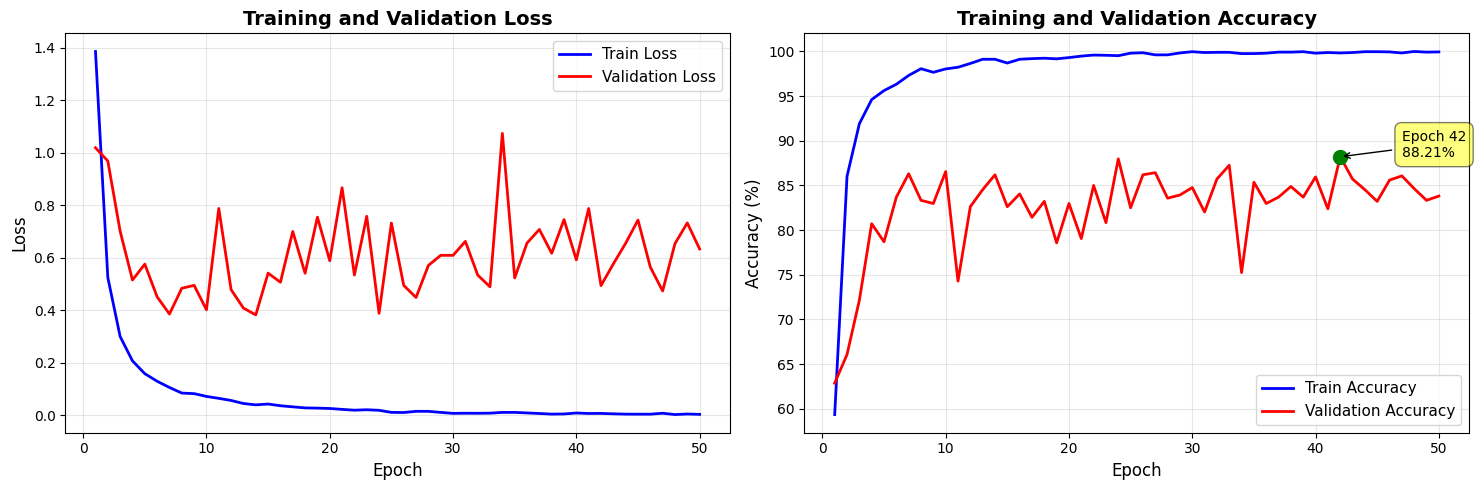


=== Training Statistics ===
Best Validation Accuracy: 88.21% (Epoch 42)
Final Train Accuracy: 99.95%
Final Validation Accuracy: 83.81%
Final Train Loss: 0.0026
Final Validation Loss: 0.6326


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# Clear matplotlib font cache and set default font
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*Glyph.*missing.*')

try:
    fm._rebuild()
except:
    pass

# Explicitly set font to DejaVu Sans (supports English)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'axes.unicode_minus': False,
    'figure.dpi': 100,
})

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Mark best validation accuracy
best_epoch = np.argmax(history['val_acc']) + 1
best_val_acc_plot = max(history['val_acc'])
best_label = f'Best: {best_val_acc_plot:.2f}%'
axes[1].plot(best_epoch, best_val_acc_plot, 'go', markersize=10, label=best_label)
axes[1].annotate(f'Epoch {best_epoch}\n{best_val_acc_plot:.2f}%', 
                xy=(best_epoch, best_val_acc_plot), 
                xytext=(best_epoch + len(epochs_range)*0.1, best_val_acc_plot),
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()

# Save plot
plot_path = experiment_dir / 'training_curves.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Training curves saved: {plot_path}")

plt.show()

# Display statistics
print(f"\n=== Training Statistics ===")
print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")